# Introduction to single-cell multi-view profiler (scMVP_regress)
In this introductory tutorial, we present the different tasks of a scMVP workflow
1. Loading the multi-omics data
2. Training the multi-view model
3. Retrieving the common latent space and imputed multi-omics values
4. Perform cell clustering and differential expression 
5. Visualize the common latent space and clustering with umap
6. The differential gene cluster identification
7. Linking CREs to gene clusters with partial least square regression

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use('WXAgg')
import random
from scvi.dataset import  snareDataset, ATACDataset, geneDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
from scvi.inference import MultiPosterior, MultiTrainer
import torch

from scvi.models.multi_vae import Multi_VAE

from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
## Visualizing the latent space with scanpy
import scanpy as sc
import anndata
import seaborn as sns

[2020-09-06 13:39:15,825] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
E:\Users\A502\Anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


## Loading data

 loading the mouse brain dataset described in Song chen et al. (2019).

* Song chen, et al. "High-throughput sequencing of the transcriptome and chromatin accessibility in the same cell" Nat Biotechnol 37 (2019): 1452-1457. 

In [2]:
def allow_mmvae_for_test():
    print("Testing the complete tutorial scMVP")

test_mode = False
save_path = "data/"
n_epochs_all = None
show_plot = True

if not test_mode:
    save_path = "E:/data/qiliu/single-cell program/ATAC/snare data/"
    
dataset = snareDataset(dataset_name="P0_BrainCortex", save_path=save_path, measurement_names_column=1, is_binary = True)

[2020-09-06 13:39:23,556] INFO - scvi.dataset.snareDataset | Preprocessing dataset
[2020-09-06 13:39:52,501] INFO - scvi.dataset.snareDataset | Finished preprocessing dataset
[2020-09-06 13:39:57,173] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-06 13:39:57,179] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-06 13:40:09,342] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-06 13:40:10,140] INFO - scvi.dataset.dataset | Downsampled from 5081 to 5081 cells


## data filtering 

In [3]:
def filter_dataset(dataset):
    high_count_genes = (dataset.X >0 ).sum(axis=0).ravel() > 0.01 * dataset.X.shape[0]
    dataset.update_genes(high_count_genes)
    dataset.subsample_genes(new_n_genes=10000)

    high_gene_count_cells = (dataset.X > 0 ).sum(axis=1).ravel() > 50
    extreme_gene_count_cells = (dataset.X).sum(axis=1).ravel() < 2000 # p0_2 multivae model
    high_gene_count_cells = np.logical_and(high_gene_count_cells,extreme_gene_count_cells)
    high_atac_cells = dataset.atac_expression.sum(axis=1) >= np.percentile(dataset.atac_expression.sum(axis=1), 1)
    inds_to_keep = np.logical_and(high_gene_count_cells, high_atac_cells)
    dataset.update_cells(inds_to_keep)

    return dataset, inds_to_keep

if test_mode is False:
    dataset, inds_to_keep = filter_dataset(dataset)

[2020-09-06 13:40:11,174] INFO - scvi.dataset.dataset | Downsampling from 19322 to 7602 genes
[2020-09-06 13:40:11,649] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-06 13:40:12,038] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-09-06 13:40:16,781] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-06 13:40:16,944] INFO - scvi.dataset.dataset | Downsampled from 5081 to 5081 cells
[2020-09-06 13:40:16,948] INFO - scvi.dataset.dataset | Not subsampling. Expecting: 1 < (new_n_genes=10000) <= self.nb_genes
[2020-09-06 13:40:20,065] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-06 13:40:20,231] INFO - scvi.dataset.dataset | Downsampled from 5081 to 5030 cells


* __n_epochs__: Maximum number of epochs to train the model. If the likelihood change is small than a set threshold training will stop automatically. 
* __lr__: learning rate. Set to 0.001 here. 
* __use_batches__: If the value of true than batch information is used in the training. Here it is set to false because the cortex data only contains one batch. 
* __use_cuda__: Set to true to use CUDA (GPU required) 
* __n_centroids__: Set the number of cell types
* __n_alfa__: Set the weight of KL loss

In [4]:
n_epochs = 100 if n_epochs_all is None else n_epochs_all
lr = 1e-3
use_batches = False
use_cuda = True
n_centroids = 19
n_alfa = 1.0

## Pre-training
runing pre-train vae to initialize the Gaussian Mixture Model

... storing 'cell_type' as categorical


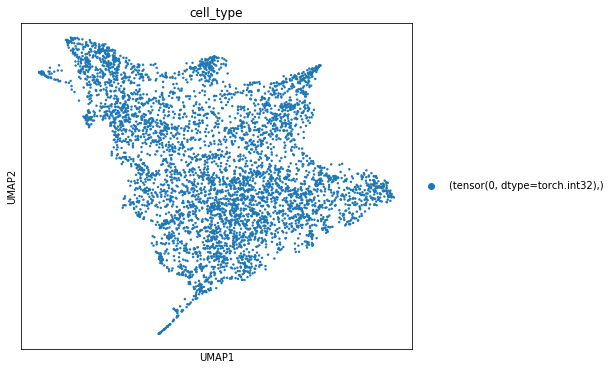

In [5]:
pre_vae = VAE(dataset.nb_genes, n_batch=256)
pre_trainer = UnsupervisedTrainer(
    pre_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)

is_test_pragram = False
if is_test_pragram:
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/pre_trainer_p0_2.pkl' % save_path)

if os.path.isfile('%s/pre_trainer_p0_2.pkl' % save_path):
    pre_trainer.model.load_state_dict(torch.load('%s/pre_trainer_p0_2.pkl' % save_path))
    pre_trainer.model.eval()
else:
    pre_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(pre_trainer.model.state_dict(), '%s/pre_trainer_p0_2.pkl' % save_path)

# pretrainer_posterior:
full = pre_trainer.create_posterior(pre_trainer.model, dataset, indices=np.arange(len(dataset)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

sample_latents = torch.tensor([])
samples = torch.tensor([])
sample_labels = torch.tensor([])
for tensors_list in range(int(len(imputed_values)/256)+1):
    if tensors_list == range(int(len(imputed_values)/256)):
        x = torch.zeros((256,len(imputed_values[0])))
        x[0:len(x)-256*tensors_list,:] = torch.tensor(imputed_values[tensors_list * 256:len(imputed_values), :])
        y = torch.zeros((256))
        y[0:len(x)-256*tensors_list,:]  = torch.tensor(dataset.labels[tensors_list * 256:len(imputed_values)].astype(int))
        temp_samples = pre_trainer.model.get_latents(x,y)
        for temp_sample in temp_samples:
            sample_latents = torch.cat((sample_latents, temp_sample[0:len(x)-256*tensors_list,:].float()))
    temp_samples = pre_trainer.model.get_latents(
        x=torch.tensor(imputed_values[tensors_list * 256:(1 + tensors_list) * 256, :]),
        y=torch.tensor(dataset.labels[tensors_list * 256:(1 + tensors_list) * 256].astype(int)))
    for temp_sample in temp_samples:
        sample_latents = torch.cat((sample_latents, temp_sample.float()))
        
# visulization
prior_adata = anndata.AnnData(X=dataset.X)
prior_adata.obsm["X_multi_vi"] = sample_latents.detach().numpy()
prior_adata.obs['cell_type'] = torch.tensor(dataset.labels[0:len(sample_latents)].astype(int))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(prior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(prior_adata, color=["cell_type"], ax=ax, show=show_plot)

sample_latents = latent

# Training scMVP
We now create the scMVP model and the trainer object.

If a pre-trained model already exist in the save_path then load the same model rather than re-training it. This is particularly useful for large datasets.

In [6]:
multi_vae = Multi_VAE(dataset.nb_genes, len(dataset.atac_names), n_batch=256, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type

trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)

clust_index_gmm = trainer.model.init_gmm_params(sample_latents)
# scvi gmm clustering
prior_adata.obs['cell_type'] = torch.tensor(clust_index_gmm.reshape(-1,1))
sc.pp.neighbors(prior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(prior_adata, min_dist=0.1)

is_test_pragram = False
if is_test_pragram:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_p0_2.pkl' % save_path)

if os.path.isfile('%s/multi_vae_p0_2.pkl' % save_path):
    trainer.model.load_state_dict(torch.load('%s/multi_vae_p0_2.pkl' % save_path))
    trainer.model.eval()
else:
    trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_p0_2.pkl' % save_path)

Plotting the likelihood change across the n epochs of training: blue for training error and orange for testing error.**

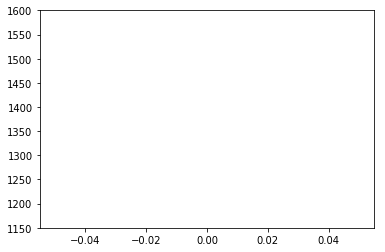

In [7]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 500, (len(elbo_train_set)))
plt.plot(x, elbo_train_set)
plt.plot(x, elbo_test_set)
plt.ylim(1150, 1600)
plt.show()

query the imputed values via the `imputation` method of the posterior object and get common latent embedding. **Note for advanced users:** imputation is an ambiguous term and there are two ways to perform imputation in scVI. The first way is to query the **mean of the negative binomial** distribution modeling the counts. This is referred to as `sample_rate` in the codebase and can be reached via the `imputation` method. The second is to query the **normalized mean of the same negative binomial** (please refer to the scVI manuscript). This is referred to as `sample_scale` in the codebase and can be reached via the `get_sample_scale` method. In differential expression for example, we of course rely on the normalized latent variable which is corrected for variations in sequencing depth.

In [8]:
full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
imputed_values = full.sequential().imputation()
sample_latents = torch.tensor([])
sample_labels = torch.tensor([])
rna_imputation = imputed_values[0]
atac_imputation = imputed_values[3]
temp_label = []
sample_latents = torch.tensor([])
samples = torch.tensor([])
sample_labels = torch.tensor([])
if len(imputed_values) >= 3:
    temp_label = imputed_values[2]
for tensors_list in range(int(len(imputed_values[0])/256)+1):
    if temp_label.any():
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256])) 
    else:
        temp_samples = trainer.model.get_latents(x_rna=torch.tensor(rna_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                x_atac=torch.tensor(atac_imputation[tensors_list*256:(1+tensors_list)*256,:]),
                                                y=torch.tensor(np.zeros(256))) 
    for temp_sample in temp_samples:
        #sample_latents = torch.cat((sample_latents, temp_sample[2].float()))
        sample_latents = torch.cat((sample_latents, temp_sample[0][0].float()))
        sample_labels = torch.cat((sample_labels, torch.tensor(temp_label[tensors_list*256:(1+tensors_list)*256]).float()))


## cell clustering
cell clustering and merging the rare clusters which less than 10 cells

In [9]:
clust_index_gmm = trainer.model.init_gmm_params(sample_latents.detach().numpy())
gmm_clus_index = clust_index_gmm.reshape(-1,1)
for i in range(len(np.unique(gmm_clus_index))):
    if len(gmm_clus_index[gmm_clus_index == i]) <= 10:
        for j in range(len(np.unique(gmm_clus_index))):
            if len(gmm_clus_index[gmm_clus_index == j]) > 100:
                gmm_clus_index[gmm_clus_index == i] = j
                break
unique_gmm_clus_index = np.unique(gmm_clus_index)
for i in range(len(unique_gmm_clus_index)):
    gmm_clus_index[gmm_clus_index == unique_gmm_clus_index[i]] = i

Visualizing common latent embedding and cell clustering by scMVP

... storing 'cell_type' as categorical


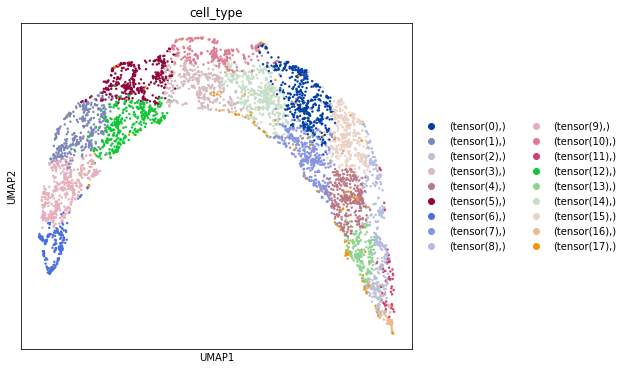

E:\Users\A502\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
... storing 'cell_type' as categorical


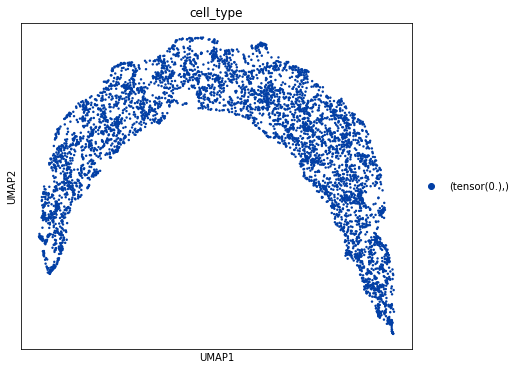

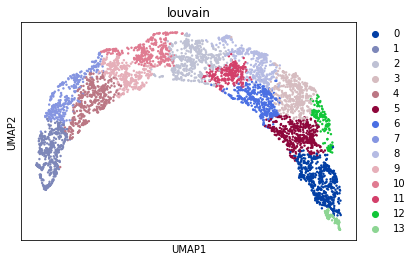

In [10]:
posterior_adata = anndata.AnnData(X=rna_imputation)
posterior_adata.obsm["X_multi_vi"] = sample_latents.detach().numpy()
posterior_adata.obs['cell_type'] = torch.tensor(clust_index_gmm.reshape(-1,1))
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
# imputation labels
posterior_adata.obs['cell_type'] = torch.tensor(sample_labels.reshape(-1,1))
sc.pp.neighbors(posterior_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(posterior_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.pl.umap(posterior_adata, color=["cell_type"], ax=ax, show=show_plot)
sc.tl.louvain(posterior_adata)
sc.pl.umap(posterior_adata, color=['louvain'])

## differential gene analysis
differential gene identification 

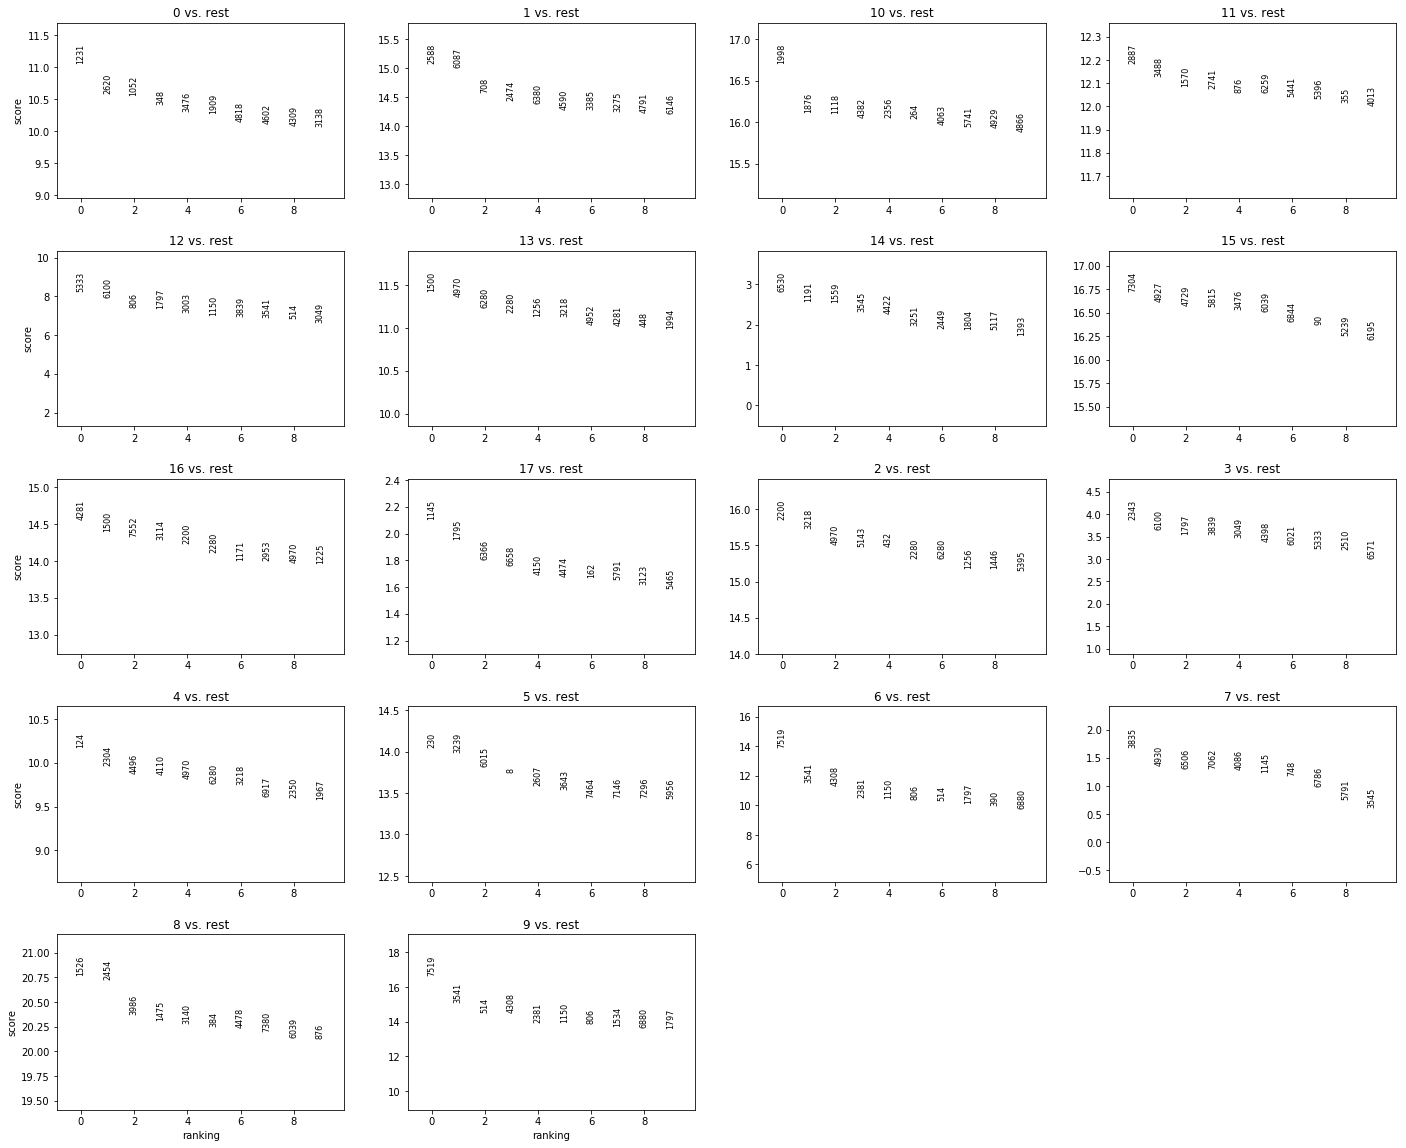

In [11]:
posterior_adata.obs['louvain'] = pd.Categorical((gmm_clus_index.T)[0].astype(np.str))
sc.tl.rank_genes_groups(posterior_adata, 'louvain')
sc.pl.rank_genes_groups(posterior_adata, n_genes=10, sharey=False)
diff_top_gene_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_set = (diff_top_gene_set['names'])
diff_top_gene_set = diff_top_gene_set[0:50]

diff_top_gene_pvalue_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_pvalue_set = (diff_top_gene_pvalue_set['pvals_adj'])
diff_top_gene_pvalue_set = diff_top_gene_pvalue_set[0:50]

diff_top_gene_foldchange_set = posterior_adata.uns['rank_genes_groups']
diff_top_gene_foldchange_set = (diff_top_gene_foldchange_set['logfoldchanges'])
diff_top_gene_foldchange_set = diff_top_gene_foldchange_set[0:50]

diff_top_gene_matrix = np.array([])
diff_top_gene_pvalue_matrix = np.array([])
diff_top_gene_foldchange_matrix = np.array([])
for i in range(len(diff_top_gene_set.dtype.descr)):
    if i == 0:
        diff_top_gene_matrix = diff_top_gene_set[str(i)].astype(np.int32)
        diff_top_gene_pvalue_matrix = diff_top_gene_pvalue_set[str(i)].astype(np.float)
        diff_top_gene_foldchange_matrix = diff_top_gene_foldchange_set[str(i)].astype(np.float)
    else:
        diff_top_gene_matrix = np.vstack((diff_top_gene_matrix,diff_top_gene_set[str(i)].astype(np.int32)))
        diff_top_gene_pvalue_matrix = np.vstack((diff_top_gene_pvalue_matrix, diff_top_gene_pvalue_set[str(i)].astype(np.float)))
        diff_top_gene_foldchange_matrix = np.vstack(
            (diff_top_gene_foldchange_matrix, diff_top_gene_foldchange_set[str(i)].astype(np.float)))
diff_top_gene_unique = np.unique(diff_top_gene_matrix.flatten())

## differential ATAC peaks analysis

peaks aggregation 

In [12]:
atac_expression = atac_imputation.T
atac_name = dataset.atac_names
cell_name = dataset.barcodes
knn_matrix = posterior_adata.add['neighbors']
knn_matrix = knn_matrix['distances']
cluster_ID = posterior_adata.obs['louvain'].as_matrix()
cluster_ID_unique = np.unique(cluster_ID)
is_cluster_dataset = False
if is_cluster_dataset:
    cluster_ID_index = cluster_ID == cluster_ID_unique[0]
    knn_cluster_matrix = knn_matrix[np.ix_(cluster_ID_index, cluster_ID_index)].A
    rank_knn = np.argpartition(knn_cluster_matrix, -3)[:, -3:]
    atac_cluster_expression = atac_expression[:, cluster_ID_index]
    for i in range(np.size(atac_cluster_expression, 1)):
        atac_cluster_expression[:, i] += np.sum(atac_cluster_expression[:, rank_knn[i, :]], axis=1)
    atac_cluster_expression[atac_cluster_expression > 1] = 1
else:
    for i in range(len(cluster_ID_unique)):
        cluster_ID_index = cluster_ID == cluster_ID_unique[i]
        knn_cluster_matrix = knn_matrix[np.ix_(cluster_ID_index, cluster_ID_index)].A
        rank_knn = np.argpartition(knn_cluster_matrix, -3)[:, -3:]
        atac_cluster_expression = atac_expression[:, cluster_ID_index]
        for j in range(np.size(atac_cluster_expression, 1)):
            atac_cluster_expression[:, j] += np.sum(atac_cluster_expression[:, rank_knn[j, :]], axis=1)
        atac_cluster_expression[atac_cluster_expression > 1] = 1
        atac_expression[:,cluster_ID_index] = atac_cluster_expression


E:\Users\A502\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Use uns instead of add, add will be removed in the future.
  after removing the cwd from sys.path.
E:\Users\A502\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


differential ATAC peaks analysis

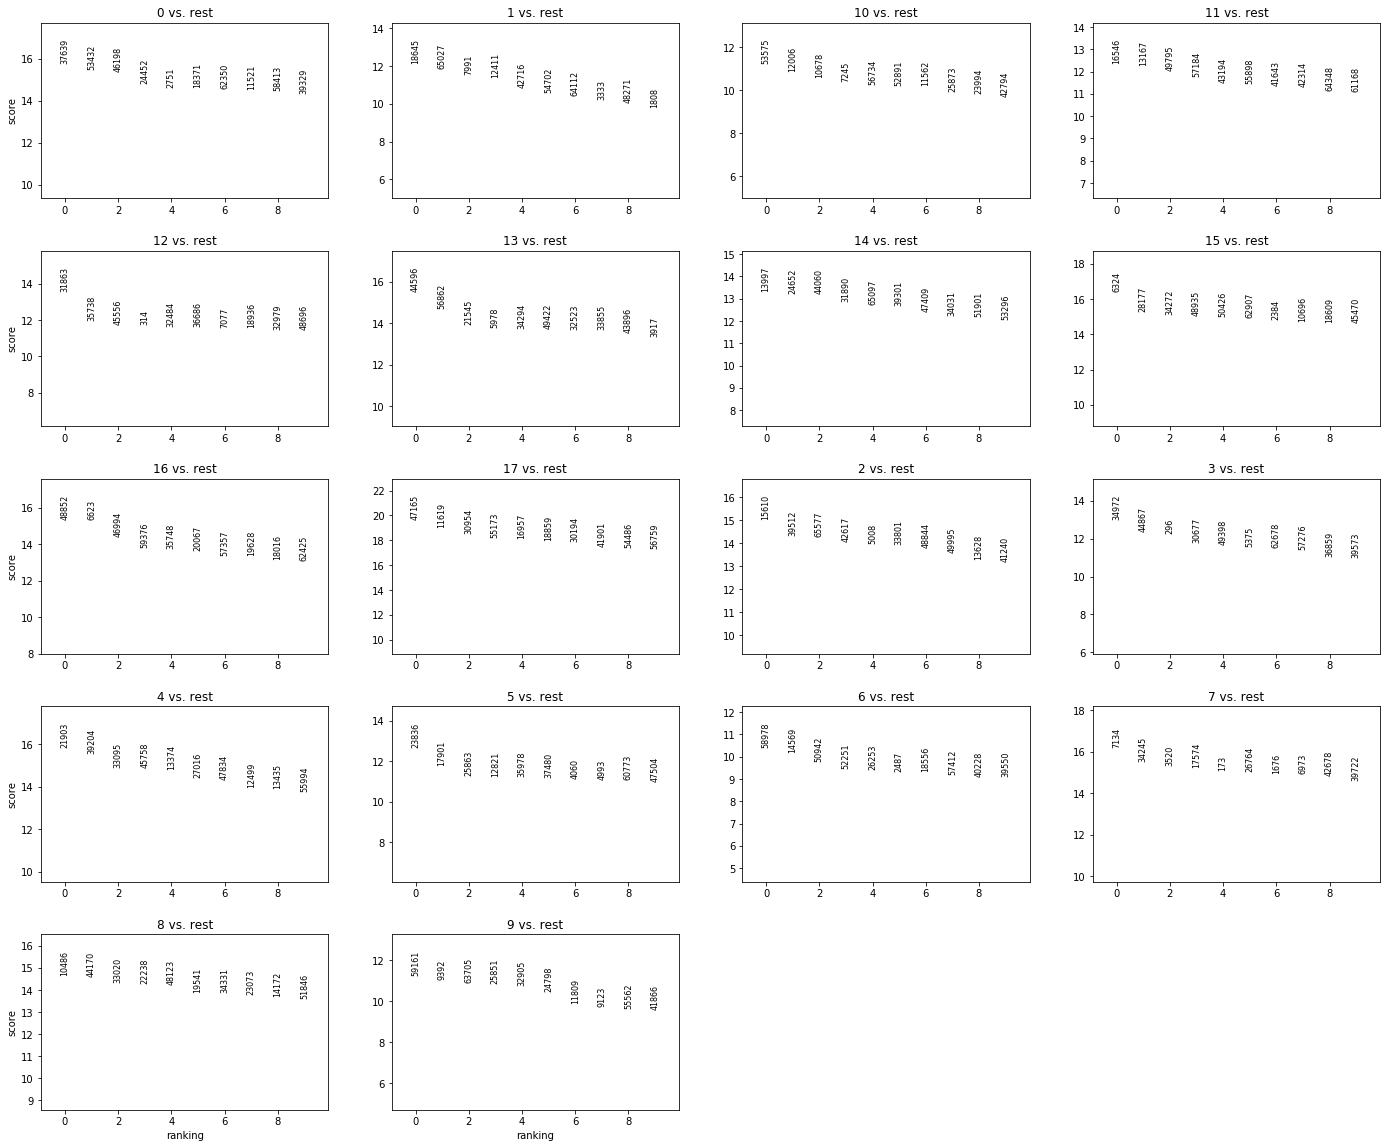

In [13]:
atac_posterior_adata = anndata.AnnData(X=atac_expression.T)
atac_posterior_adata.obs['louvain'] = posterior_adata.obs['louvain']
sc.tl.rank_genes_groups(atac_posterior_adata, 'louvain',n_genes=1000)
sc.pl.rank_genes_groups(atac_posterior_adata, n_genes=10, sharey=False)
atac_diff_top_gene_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_set = (atac_diff_top_gene_set['names'])
atac_diff_top_gene_pvalue_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_pvalue_set = (atac_diff_top_gene_pvalue_set['pvals_adj'])
atac_diff_top_gene_foldchange_set = atac_posterior_adata.uns['rank_genes_groups']
atac_diff_top_gene_foldchange_set = (atac_diff_top_gene_foldchange_set['logfoldchanges'])


# differential gene module

[2020-09-06 13:42:43,121] INFO - scvi.dataset.geneDataset | Preprocessing dataset
[2020-09-06 13:42:43,594] INFO - scvi.dataset.geneDataset | Finished preprocessing dataset
[2020-09-06 13:42:43,735] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-09-06 13:42:43,738] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-09-06 13:42:43,843] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-09-06 13:42:43,969] INFO - scvi.dataset.dataset | Downsampled from 7602 to 7602 cells


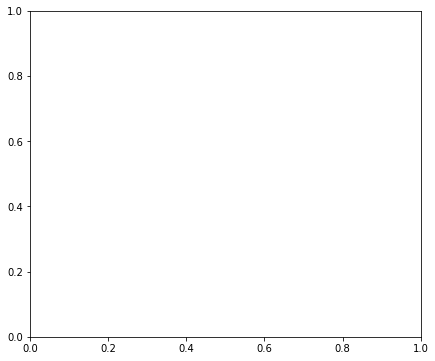

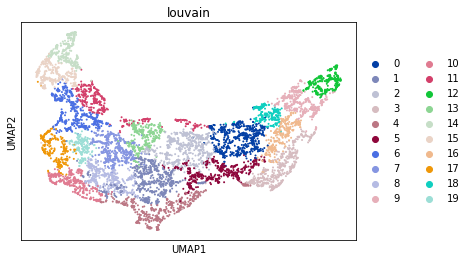

E:\Users\A502\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
E:\Users\A502\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [14]:
gene_expression = rna_imputation.T
for i in range(len(gene_expression)):
    gene_expression[i, :] = np.log1p(gene_expression[i, :]) / np.log1p(np.max(gene_expression[i, :])) + 0.0001
gene_exp_data = geneDataset(gene_expression, dataset.gene_names, dataset.barcodes)
gene_exp_vae = VAE(gene_exp_data.nb_genes, n_batch=256)
gene_exp_trainer = UnsupervisedTrainer(
    gene_exp_vae,
    gene_exp_data,
    train_size=0.75,
    use_cuda=use_cuda,
    frequency=5,
)
is_test_pragram = False

if is_test_pragram:
    gene_exp_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(gene_exp_trainer.model.state_dict(), '%s/gene_exp_trainer_p0_8.pkl' % save_path)

if os.path.isfile('%s/gene_exp_trainer_p0_8.pkl' % save_path):
    gene_exp_trainer.model.load_state_dict(torch.load('%s/gene_exp_trainer_p0_8.pkl' % save_path))
    gene_exp_trainer.model.eval()
else:
    gene_exp_trainer.train(n_epochs=n_epochs, lr=lr)
    torch.save(gene_exp_trainer.model.state_dict(), '%s/gene_exp_trainer_p0_8.pkl' % save_path)
    
# visulization
full = gene_exp_trainer.create_posterior(gene_exp_trainer.model, gene_exp_data, indices=np.arange(len(gene_exp_data)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()
gene_exp_adata = anndata.AnnData(X=gene_exp_data.X)
gene_exp_adata.obsm["X_multi_vi"] = latent
sc.pp.neighbors(gene_exp_adata, use_rep="X_multi_vi", n_neighbors=15)
sc.tl.umap(gene_exp_adata, min_dist=0.1)
fig, ax = plt.subplots(figsize=(7, 6))
sc.tl.louvain(gene_exp_adata)
sc.pl.umap(gene_exp_adata, color=['louvain'])

# diff gene cluster
cell_clu_index = posterior_adata.obs['louvain'].as_matrix().astype(np.int32)
gene_clu_index = gene_exp_adata.obs['louvain'].as_matrix().astype(np.int32)
diff_rank_gene_clu_index = gene_clu_index[diff_top_gene_unique]
gene_clu_index_unique, gene_clu_index_counts = np.unique(gene_clu_index,return_counts = True)
diff_rank_gene_clu_index_unique, diff_rank_gene_clu_index_counts = np.unique(diff_rank_gene_clu_index,return_counts = True)
diff_rank_gene_clu_filter = np.where(diff_rank_gene_clu_index_counts >= 0.04*np.sum(diff_rank_gene_clu_index_counts))
diff_rank_gene_clu_filter_matrix = np.zeros((2,len(diff_rank_gene_clu_filter[0])))
diff_rank_gene_clu_filter_matrix[0,:] = diff_rank_gene_clu_index_unique[diff_rank_gene_clu_filter[0]]
diff_rank_gene_clu_filter_matrix[1,:] = diff_rank_gene_clu_index_counts[diff_rank_gene_clu_filter[0]]

# CRE regress for differential gene module using PLS

In [15]:
gene_cluster_ID = gene_exp_adata.obs['louvain'].as_matrix()
gene_cluster_specific_atac = None
gene_cluster_ID_unique = diff_rank_gene_clu_filter_matrix[0,:].astype(np.int32) # for the filtered diff gene set
n_components = 40
selected_feature_R2 = None
selected_feature_R2_index = None
PLS_predict_gene_exp_corr = np.array([])
PLS_predict_gene_exp_corr_index = np.array([])

for i in range(len(gene_cluster_ID_unique)):
    x_train, x_test, y_train, y_test = train_test_split(atac_expression.T,
                                                        gene_expression[
                                                        gene_cluster_ID.astype(np.int32) == gene_cluster_ID_unique[
                                                            i].astype(np.int32), :].T,
                                                        test_size=0.1,
                                                        random_state=33)
    pls = PLSRegression(n_components=n_components, scale=False)
    pls.fit(x_train, y_train)  
    y_pls_predict = pls.predict(x_test)
    test_pls_error = np.mean((y_pls_predict - y_test) ** 2, axis=0)
    test_pls_R2 = np.zeros(y_test.shape[0])
    for j in range(y_test.shape[0]):
        test_pls_R2[j] = np.corrcoef(y_pls_predict[j,:], y_test[j,:])[0,1]
    PLS_predict_gene_exp_corr = np.append(PLS_predict_gene_exp_corr,test_pls_R2)
    PLS_predict_gene_exp_corr_index = np.append(PLS_predict_gene_exp_corr_index,i*np.ones(len(test_pls_R2)).astype(np.int))
   
    test_pls_error = np.mean((y_pls_predict - y_test) ** 2, axis=0)
    indices_pls = np.argsort(np.abs(pls.coef_).T)[:, ::-1].T
    selected_pls_feature_index = indices_pls[0:5000, :]
     # R2
    for j in range(np.size(y_pls_predict,axis=1)):
        if selected_feature_R2 is None:
            selected_feature_R2 = np.array([r2_score(y_pls_predict[:,j],y_test[:,j])])
            selected_feature_R2_index= gene_cluster_ID_unique[i]
        else:
            selected_feature_R2 = np.hstack((selected_feature_R2,np.array([r2_score(y_pls_predict[:,j], y_test[:,j])])))
            selected_feature_R2_index = np.append(selected_feature_R2_index,gene_cluster_ID_unique[i])
            
# visualizing correlation between the PLS regression and gene expression
R2_df = pd.DataFrame(np.vstack((selected_feature_R2_index.flatten(),selected_feature_R2.flatten())).T,columns=['clusters', 'R2'])
sns.violinplot(x="clusters", y="R2", data=R2_df,
            linewidth = 2,   
            width = 0.8,     
            palette = 'hls', 
            scale = 'area',  
            gridsize = 50,   
            inner = 'box'
           )
plt.show()
R2_df = pd.DataFrame(np.vstack((PLS_predict_gene_exp_corr_index,np.abs(PLS_predict_gene_exp_corr))).T,columns=['clusters', 'corr'])
sns.violinplot(x="clusters", y="corr", data=R2_df,
            linewidth = 2,   
            width = 0.8,     
            palette = 'hls', 
            scale = 'area',  
            gridsize = 50,   
            inner = 'box'
           )
plt.show()

SyntaxError: invalid syntax (<ipython-input-15-43bdbe3bd4e7>, line 51)